In [10]:
# Read _results; Six types of execution multiplier chart+ TVR Fees analysis+ SARIMA
import os, glob, math, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.stattools import jarque_bera
from sklearn.linear_model import LinearRegression
from statsmodels.stats.stattools import jarque_bera
from statsmodels.stats.diagnostic import het_arch
from scipy.stats import pearsonr, spearmanr

warnings.filterwarnings("ignore")


In [11]:
# basic settings
RESULTS_DIR = "./_results"
PANEL_PATH = os.path.join(RESULTS_DIR, "panel_with_flags.csv")
COVER_PATH = os.path.join(RESULTS_DIR, "category_coverage_report.csv")
OUTDIR = "./_cat_results2"
os.makedirs(OUTDIR, exist_ok=True)

START = pd.Timestamp("2022-04-01")
END   = pd.Timestamp("2025-05-01")
SEASONAL_S = 7            
MIN_LEN_FOR_MODEL = 100   # Modeling minimum effective sample points

In [12]:
def _winsorize(s: pd.Series, p=0.01):
    if s.isna().all():
        return s
    lo, hi = s.quantile(p), s.quantile(1-p)
    return s.clip(lo, hi)

def _safe_log(s: pd.Series):
    return np.where(s > 0, np.log(s), np.nan)

def choose_d_by_adf(y: pd.Series, max_d=2, alpha=0.05):
    """Select d step by step according to ADF differential selection (try to minimize d to make it stable)"""
    d = 0
    cur = y.dropna()
    while d < max_d:
        if len(cur) < 30:
            break
        pval = adfuller(cur, autolag="AIC")[1]
        if pval < alpha:
            break  # Already stable
        d += 1
        cur = cur.diff().dropna()
    return d

def choose_D_weekly(y: pd.Series, alpha=0.05):
    """Select whether to perform weekly seasonal differencing (D=1)"""
    if len(y.dropna()) < 30:
        return 0
    # Rough judgement: If y is more stable after its 7 lag differences, then take D=1.
    p0 = adfuller(y.dropna(), autolag="AIC")[1]
    p1 = adfuller(y.diff(SEASONAL_S).dropna(), autolag="AIC")[1]
    return 1 if (p1 < alpha and (math.isnan(p0) or p0 >= alpha)) else 0

def grid_search_sarima(y: pd.Series, d, D, s=SEASONAL_S,
                       p_range=range(0,3), q_range=range(0,3),
                       P_range=range(0,2), Q_range=range(0,2)):
    """Simple grid search, select the minimum AIC"""
    best = {"aic": np.inf, "order": None, "sorder": None, "model": None}
    for p in p_range:
        for q in q_range:
            for P in P_range:
                for Q in Q_range:
                    try:
                        m = SARIMAX(y, order=(p,d,q), seasonal_order=(P,D,Q,s),
                                    enforce_stationarity=False, enforce_invertibility=False)
                        res = m.fit(disp=False)
                        if res.aic < best["aic"]:
                            best = {
                                "aic": res.aic, "order": (p,d,q),
                                "sorder": (P,D,Q,s), "model": res
                            }
                    except Exception:
                        continue
    return best

def save_fig(fig, path):
    fig.tight_layout()
    fig.savefig(path, dpi=150, bbox_inches="tight")
    plt.close(fig)

In [ ]:
# read data
assert os.path.exists(PANEL_PATH), f"cannot find {PANEL_PATH}"
assert os.path.exists(COVER_PATH), f"cannot find {COVER_PATH}"

panel = pd.read_csv(PANEL_PATH, parse_dates=["date"])
panel["date"] = panel["date"].dt.tz_convert("UTC").dt.tz_localize(None)  # Remove time zone
cover = pd.read_csv(COVER_PATH)

# Take the categories pass the ARIMA/SARIMA (ok_arima_tvr=True)
pass_cats = cover.loc[cover["ok_arima_tvr"], "category"].tolist()
print("✓ Categories of analysis：", pass_cats)

# Retain only time window
panel = panel[(panel["date"] >= START) & (panel["date"] <= END)].copy()
panel = panel.sort_values(["category","date"]).reset_index(drop=True)


EVENTS = [
    # Interval events: Use shadows
    {"name": "LUNA Collapse", "start": "2022-05-09", "end": "2022-05-12"},
    {"name": "FTX Collapse",  "start": "2022-11-08", "end": "2022-11-11"},
    # Single-day events: Use vertical lines
    {"name": "The Merge",     "date":  "2022-09-15"},
    {"name": "Shapella",      "date":  "2023-04-12"},  # ETH withdrawals available.
]

def add_events(ax, index_like):
    y_top = ax.get_ylim()[1]
    for ev in EVENTS:
        if "start" in ev:
            s = pd.to_datetime(ev["start"]); e = pd.to_datetime(ev["end"])
            ax.axvspan(s, e, alpha=0.12)
            ax.text(s, y_top, ev["name"], rotation=90, va="top", ha="left", fontsize=9)
        else:
            d = pd.to_datetime(ev["date"])
            ax.axvline(d, linestyle="--", linewidth=1)
            ax.text(d, y_top, ev["name"], rotation=90, va="top", ha="center", fontsize=9)

✓ Categories of analysis： ['Liquid Staking', 'Lending', 'Yield', 'CDP', 'Dexs', 'Onchain Capital Allocator']


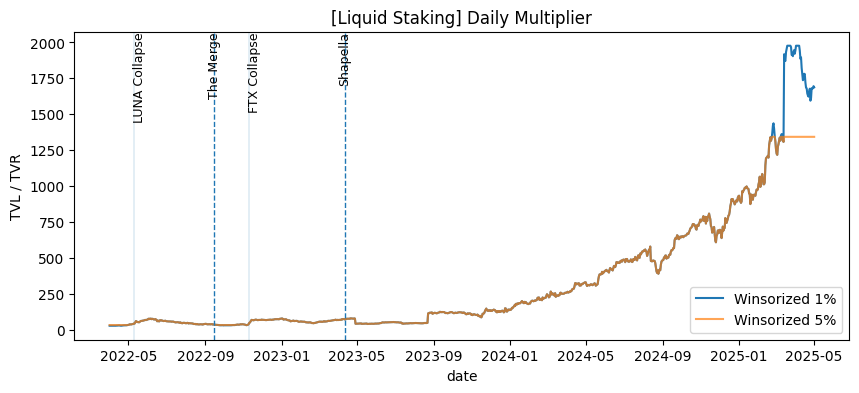

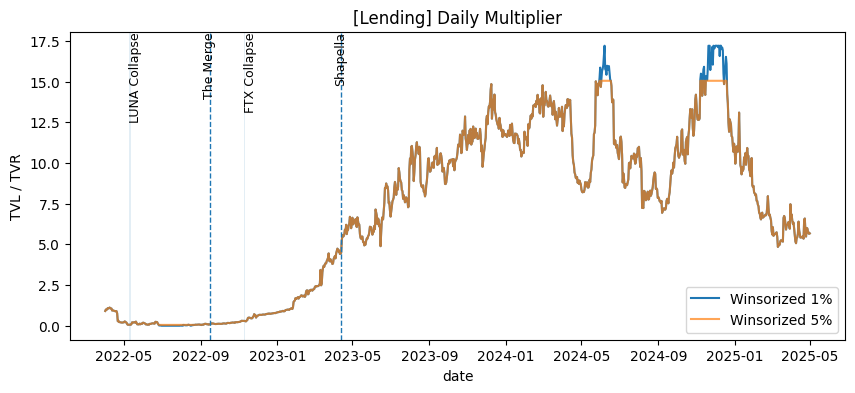

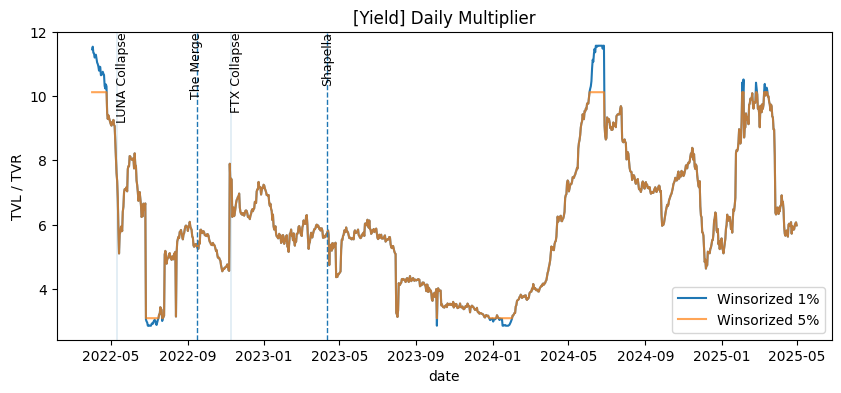

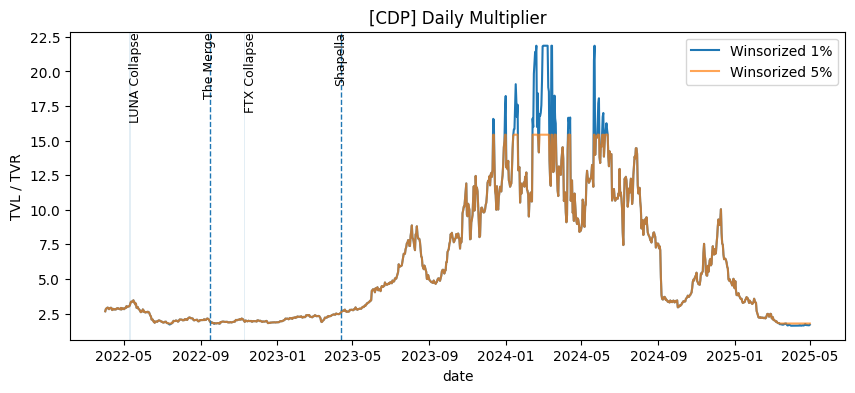

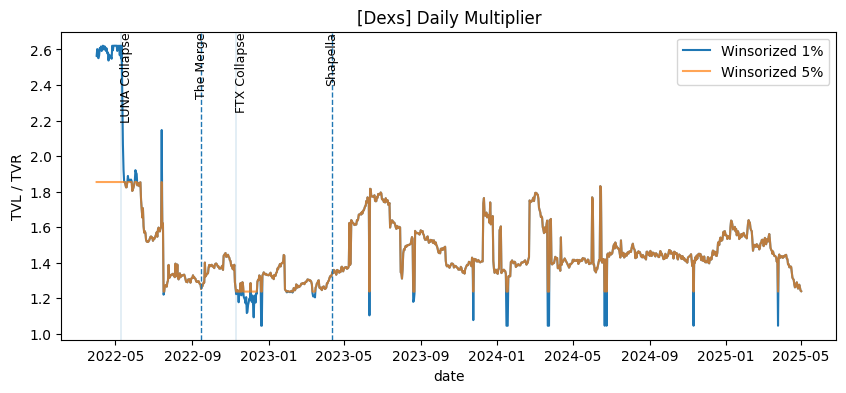

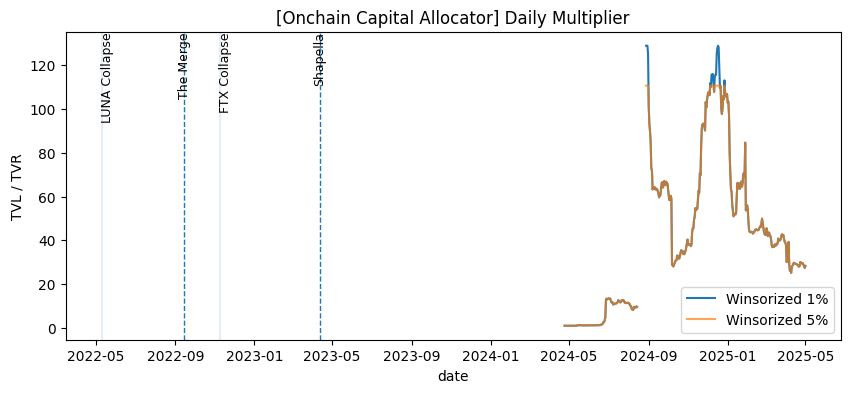

In [15]:
from scipy.stats import pearsonr, spearmanr
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from scipy.stats import kendalltau   # 🔥 put at top of script with other imports


def _winsorize(s, p=0.01):
    s = pd.to_numeric(s, errors="coerce")
    lo, hi = s.quantile(p), s.quantile(1-p)
    return s.clip(lo, hi)

def _safe_log(s):
    s = pd.to_numeric(s, errors="coerce")
    return np.where(s > 0, np.log(s), np.nan)

cats = pass_cats if 'pass_cats' in globals() else (
    cover.loc[cover.get('ok_arima_tvr', True), 'category'].tolist()
)

summary_rows = []        
corr_rows = []      

for cat in cats:
    # 1. Retrieving data and indexing
    g = panel.loc[panel["category"] == cat].copy()
    if g.empty:
        continue
    g = g.sort_values("date").set_index("date")

    # 2. Multiplier stabilisation
    # 2. Multiplier stabilisation (1% and 5%)
    if "mult_daily" in g.columns:
        g["mult_daily_w1"] = _winsorize(g["mult_daily"].astype(float), p=0.01)
        g["mult_daily_w5"] = _winsorize(g["mult_daily"].astype(float), p=0.05)
    else:
        g["mult_daily_w1"] = np.nan
        g["mult_daily_w5"] = np.nan

    # picture 1：multiplier (compare 1% vs 5%)
    fig1 = plt.figure(figsize=(10,4))
    ax1 = fig1.add_subplot(111)
    ax1.plot(g.index, g["mult_daily_w1"], label="Winsorized 1%")
    ax1.plot(g.index, g["mult_daily_w5"], label="Winsorized 5%", alpha=0.7)
    ax1.set_title(f"[{cat}] Daily Multiplier")
    ax1.set_xlabel("date"); ax1.set_ylabel("TVL / TVR")
    add_events(ax1, g.index)
    ax1.legend()


    # 3.Fees stabilisation + logarithm 
    if "Fees" in g.columns:
        g["Fees_w"]   = _winsorize(g["Fees"].astype(float), p=0.01)
        g["log_Fees"] = _safe_log(g["Fees_w"])
    else:
        g["Fees_w"] = np.nan
        g["log_Fees"] = np.nan

    # 4.Modelling sequence
    y_tvr = g["log_tvr_m"].dropna() if "log_tvr_m" in g.columns else pd.Series(dtype=float)
    y_tvl = g["log_tvl_m"].dropna() if "log_tvl_m" in g.columns else pd.Series(dtype=float)

    fig1 = plt.figure(figsize=(10,4))
    ax1 = fig1.add_subplot(111)
    ax1.plot(g.index, g["mult_daily_w1"], label="Winsorized 1%")
    # optional: also plot the 5% for comparison
    ax1.plot(g.index, g["mult_daily_w5"], label="Winsorized 5%", alpha=0.7)
    ax1.set_title(f"[{cat}] Daily Multiplier")
    ax1.set_xlabel("date"); ax1.set_ylabel("TVL / TVR")
    add_events(ax1, g.index)
    ax1.legend()
    save_fig(fig1, os.path.join(OUTDIR, f"{cat}_multiplier_daily.png"))


    # 5. Correlation and regression
    # TVR vs Fees
    beta_tvr = np.nan; r_tvr = np.nan; rho_tvr = np.nan
    df_corr_tvr = g[["log_tvr_m", "log_Fees"]].dropna() if {"log_tvr_m","log_Fees"}.issubset(g.columns) else pd.DataFrame()
    if len(df_corr_tvr) >= 30:
        X = df_corr_tvr[["log_tvr_m"]].values
        y_fee = df_corr_tvr["log_Fees"].values
        lr = LinearRegression().fit(X, y_fee)
        beta_tvr = float(lr.coef_[0]); intercept_tvr = float(lr.intercept_)
        r_tvr, p_tvr = pearsonr(df_corr_tvr["log_tvr_m"].values, df_corr_tvr["log_Fees"].values)
        rho_tvr, p_rho_tvr = spearmanr(df_corr_tvr["log_tvr_m"].values, df_corr_tvr["log_Fees"].values)

        # P2：Scatter plot + regression line
        fig2 = plt.figure(figsize=(5,5))
        ax2 = fig2.add_subplot(111)
        ax2.scatter(df_corr_tvr["log_tvr_m"], df_corr_tvr["log_Fees"], s=8)
        xline = np.linspace(df_corr_tvr["log_tvr_m"].min(), df_corr_tvr["log_tvr_m"].max(), 200)
        yline = intercept_tvr + beta_tvr * xline
        ax2.plot(xline, yline)
        ax2.text(
            0.02, 0.98,
            f"Pearson r={r_tvr:.3f} (p={p_tvr:.2g})\n"
            f"Spearman ρ={rho_tvr:.3f} (p={p_rho_tvr:.2g})\n"
            f"N={len(df_corr_tvr)}",
            transform=ax2.transAxes, va="top", ha="left",
            bbox=dict(boxstyle="round,pad=0.3", alpha=0.15)
        )
        ax2.set_title(f"[{cat}] log(Fees) vs log(TVR)  β={beta_tvr:.3f}")
        ax2.set_xlabel("log(TVR)"); ax2.set_ylabel("log(Fees)")
        save_fig(fig2, os.path.join(OUTDIR, f"{cat}_corr_logFees_logTVR.png"))
    else:
        p_tvr = p_rho_tvr = np.nan

    # TVL vs Fees
    beta_tvl = np.nan; r_tvl = np.nan; rho_tvl = np.nan
    df_corr_tvl = g[["log_tvl_m", "log_Fees"]].dropna() if {"log_tvl_m","log_Fees"}.issubset(g.columns) else pd.DataFrame()
    if len(df_corr_tvl) >= 30:
        X2 = df_corr_tvl[["log_tvl_m"]].values
        y2 = df_corr_tvl["log_Fees"].values
        lr2 = LinearRegression().fit(X2, y2)
        beta_tvl = float(lr2.coef_[0]); intercept_tvl = float(lr2.intercept_)
        r_tvl, p_tvl = pearsonr(df_corr_tvl["log_tvl_m"].values, df_corr_tvl["log_Fees"].values)
        rho_tvl, p_rho_tvl = spearmanr(df_corr_tvl["log_tvl_m"].values, df_corr_tvl["log_Fees"].values)

        # P2b：
        fig2b = plt.figure(figsize=(5,5))
        ax2b = fig2b.add_subplot(111)
        ax2b.scatter(df_corr_tvl["log_tvl_m"], df_corr_tvl["log_Fees"], s=8)
        xline2 = np.linspace(df_corr_tvl["log_tvl_m"].min(), df_corr_tvl["log_tvl_m"].max(), 200)
        yline2 = intercept_tvl + beta_tvl * xline2
        ax2b.plot(xline2, yline2)
        ax2b.text(
            0.02, 0.98,
            f"Pearson r={r_tvl:.3f} (p={p_tvl:.2g})\n"
            f"Spearman ρ={rho_tvl:.3f} (p={p_rho_tvl:.2g})\n"
            f"N={len(df_corr_tvl)}",
            transform=ax2b.transAxes, va="top", ha="left",
            bbox=dict(boxstyle="round,pad=0.3", alpha=0.15)
        )
        ax2b.set_title(f"[{cat}] log(Fees) vs log(TVL)  β={beta_tvl:.3f}")
        ax2b.set_xlabel("log(TVL)"); ax2b.set_ylabel("log(Fees)")
        save_fig(fig2b, os.path.join(OUTDIR, f"{cat}_corr_logFees_logTVL.png"))
    else:
        p_tvl = p_rho_tvl = np.nan

    #  6. SARIMA fitting
    order = sorder = None; aic = np.nan
    if len(y_tvr) >= MIN_LEN_FOR_MODEL:
        d = choose_d_by_adf(y_tvr, max_d=2, alpha=0.05)
        D = choose_D_weekly(y_tvr, alpha=0.05)
        best = grid_search_sarima(y_tvr, d=d, D=D, s=SEASONAL_S)
        if best["model"] is not None:
            res = best["model"]; order = best["order"]; sorder = best["sorder"]; aic = float(res.aic)
            try:
                res = res.model.fit(start_params=res.params, cov_type='robust', disp=False)
            except Exception:
                try:
                    res = res.model.fit(cov_type='robust', disp=False)
                except Exception:
                    pass
            pred_in = res.get_prediction(start=y_tvr.index[0], end=y_tvr.index[-1], dynamic=False)
            fit_log = pred_in.predicted_mean
            burn = getattr(res, "loglikelihood_burn", 0)
            if burn > 0:
                fit_log = fit_log.iloc[burn:]; y_plot = y_tvr.iloc[burn:]
            else:
                y_plot = y_tvr
            lo, hi = y_plot.quantile(0.001), y_plot.quantile(0.999)
            fit_log = fit_log.clip(lo, hi)
            fig3 = plt.figure(figsize=(10,4))
            ax3 = fig3.add_subplot(111)
            ax3.plot(y_plot.index, y_plot, label="log(TVR)")
            ax3.plot(fit_log.index, fit_log, label="Fitted log(TVR)")
            ax3.set_title(f"[{cat}] TVR fit (in-sample)  order={order}, seasonal={sorder}, AIC={aic:.1f}")
            ax3.set_xlabel("date"); ax3.set_ylabel("log USD"); ax3.legend()
            save_fig(fig3, os.path.join(OUTDIR, f"{cat}_tvr_fit_log.png"))

    order_tvl = sorder_tvl = None; aic_tvl = np.nan
    if len(y_tvl) >= MIN_LEN_FOR_MODEL:
        d2 = choose_d_by_adf(y_tvl, max_d=2, alpha=0.05)
        D2 = choose_D_weekly(y_tvl, alpha=0.05)
        best2 = grid_search_sarima(y_tvl, d=d2, D=D2, s=SEASONAL_S)
        if best2["model"] is not None:
            res2 = best2["model"]; order_tvl = best2["order"]; sorder_tvl = best2["sorder"]; aic_tvl = float(res2.aic)
            try:
                res2 = res2.model.fit(start_params=res2.params, cov_type='robust', disp=False)
            except Exception:
                try:
                    res2 = res2.model.fit(cov_type='robust', disp=False)
                except Exception:
                    pass
            pred_in2 = res2.get_prediction(start=y_tvl.index[0], end=y_tvl.index[-1], dynamic=False)
            fit_log2 = pred_in2.predicted_mean
            burn2 = getattr(res2, "loglikelihood_burn", 0)
            if burn2 > 0:
                fit_log2 = fit_log2.iloc[burn2:]; y_plot2 = y_tvl.iloc[burn2:]
            else:
                y_plot2 = y_tvl
            lo2, hi2 = y_plot2.quantile(0.001), y_plot2.quantile(0.999)
            fit_log2 = fit_log2.clip(lo2, hi2)
            fig3b = plt.figure(figsize=(10,4))
            ax3b = fig3b.add_subplot(111)
            ax3b.plot(y_plot2.index, y_plot2, label="log(TVL)")
            ax3b.plot(fit_log2.index, fit_log2, label="Fitted log(TVL)")
            ax3b.set_title(f"[{cat}] TVL fit (in-sample)  order={order_tvl}, seasonal={sorder_tvl}, AIC={aic_tvl:.1f}")
            ax3b.set_xlabel("date"); ax3b.set_ylabel("log USD"); ax3b.legend()
            save_fig(fig3b, os.path.join(OUTDIR, f"{cat}_tvl_fit_log.png"))

    # 7. summary
    cover_row = cover[cover["category"]==cat].iloc[0].to_dict() if "category" in cover.columns and (cover["category"]==cat).any() else {}
    summary_rows.append(dict(
        category=cat,
        n_model_obs_TVR=len(y_tvr), order_TVR=str(order), seasonal_TVR=str(sorder), AIC_TVR=aic,
        n_model_obs_TVL=len(y_tvl), order_TVL=str(order_tvl), seasonal_TVL=str(sorder_tvl), AIC_TVL=aic_tvl,
        pearson_r_TVR=r_tvr, spearman_rho_TVR=rho_tvr,
        pearson_r_TVL=r_tvl, spearman_rho_TVL=rho_tvl,
        thr=float(cover_row.get("thr", np.nan)),
        tvr_coverage=float(cover_row.get("tvr_coverage", np.nan)),
        valid_coverage=float(cover_row.get("valid_coverage", np.nan)),
        N_tvr_pos=int(cover_row.get("N_tvr_pos", 0)),
        N_active=int(cover_row.get("N_active", 0)),
    ))
    
    tau_tvr, p_tau_tvr = (np.nan, np.nan)
    if len(df_corr_tvr) >= 30:
        tau_tvr, p_tau_tvr = kendalltau(df_corr_tvr["log_tvr_m"], df_corr_tvr["log_Fees"])

    tau_tvl, p_tau_tvl = (np.nan, np.nan)
    if len(df_corr_tvl) >= 30:
        tau_tvl, p_tau_tvl = kendalltau(df_corr_tvl["log_tvl_m"], df_corr_tvl["log_Fees"])

    corr_rows.append(dict(
        category=cat,
        N_TVR=len(df_corr_tvr),
        pearson_r_TVR=r_tvr, pearson_p_TVR=p_tvr,
        spearman_rho_TVR=rho_tvr, spearman_p_TVR=p_rho_tvr,
        kendall_tau_TVR=tau_tvr, kendall_p_TVR=p_tau_tvr,   # 🔥 added

        N_TVL=len(df_corr_tvl),
        pearson_r_TVL=r_tvl, pearson_p_TVL=p_tvl,
        spearman_rho_TVL=rho_tvl, spearman_p_TVL=p_rho_tvl,
        kendall_tau_TVL=tau_tvl, kendall_p_TVL=p_tau_tvl,   # 🔥 added
        ))


    # corr_rows.append(dict(
    #     category=cat,
    #     N_TVR=len(df_corr_tvr), pearson_r_TVR=r_tvr, pearson_p_TVR=(p_tvr if 'p_tvr' in locals() else np.nan),
    #     spearman_rho_TVR=rho_tvr, spearman_p_TVR=(p_rho_tvr if 'p_rho_tvr' in locals() else np.nan),
    #     N_TVL=len(df_corr_tvl), pearson_r_TVL=r_tvl, pearson_p_TVL=(p_tvl if 'p_tvl' in locals() else np.nan),
    #     spearman_rho_TVL=rho_tvl, spearman_p_TVL=(p_rho_tvl if 'p_rho_tvl' in locals() else np.nan),
    # ))

In [16]:
# ====================== 追加：SARIMA 残差诊断（不改原循环） ======================
import os, numpy as np, pandas as pd, matplotlib.pyplot as plt
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch, normal_ad
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.graphics.gofplots import qqplot

# 可调参数
DIAG_OUTDIR = os.path.join(OUTDIR, "diagnostics")
os.makedirs(DIAG_OUTDIR, exist_ok=True)
MAKE_PLOTS = True                 # 是否输出残差图（时序/ACF/PACF/Q-Q）
LB_LAGS    = [14, 28]             # Ljung–Box 滞后
ARCH_MAXLAG_FRACTION = 10         # ARCH-LM 的 maxlag ≈ len(resid)//这个数

def _fit_and_diag_one(y: pd.Series, label: str, cat: str) -> dict:
    """
    重新拟合该序列的 SARIMA（按你现有的规则），并返回残差诊断结果字典。
    label: 'TVR' or 'TVL'
    """
    out = {
    "category": cat,
    "series": label,
    "order": None, "seasonal": None, "AIC": np.nan,
    "n_raw": int(len(y)), "n_eff": np.nan,
    "lb_p14": np.nan, "lb_p28": np.nan,
    "stable": np.nan, "invertible": np.nan,
    "jb_stat": np.nan, "jb_p": np.nan,      # 🔥 new
    "arch_stat": np.nan, "arch_p": np.nan,  # 🔥 new
        }

    if len(y) < MIN_LEN_FOR_MODEL:
        return out

    try:
        d = choose_d_by_adf(y, max_d=2, alpha=0.05)
        D = choose_D_weekly(y, alpha=0.05)
        best = grid_search_sarima(y, d=d, D=D, s=SEASONAL_S)
        if best.get("model") is None:
            return out
        res = best["model"]
        order, sorder = best["order"], best["sorder"]
        out["order"], out["seasonal"], out["AIC"] = str(order), str(sorder), float(res.aic)

        # 烧入期 & 残差
        burn = int(getattr(res, "loglikelihood_burn", 0))
        resid = res.resid
        if hasattr(resid, "iloc") and burn > 0:
            resid = resid.iloc[burn:]
        resid = resid.dropna()
        out["n_eff"] = int(getattr(res, "nobs", len(y)) - burn)
        # Jarque-Bera test (normality)
        jb_stat, jb_p, _, _ = jarque_bera(resid)
        out["jb_stat"], out["jb_p"] = jb_stat, jb_p

        # ARCH LM test (heteroskedasticity)
        maxlag = max(1, len(resid)//ARCH_MAXLAG_FRACTION)
        arch_stat, arch_p, _, _ = het_arch(resid, maxlag=maxlag)
        out["arch_stat"], out["arch_p"] = arch_stat, arch_p

        # Ljung–Box
        lags_use = [L for L in LB_LAGS if len(resid) > L]
        if lags_use:
            lb = acorr_ljungbox(resid, lags=lags_use, return_df=True)
            try:
                lb.index = lb.index.astype(int)
            except Exception:
                pass
            out["lb_p14"] = float(lb.loc[14, "lb_pvalue"]) if 14 in lb.index else np.nan
            out["lb_p28"] = float(lb.loc[28, "lb_pvalue"]) if 28 in lb.index else np.nan


        # 稳定/可逆
        ar_roots = getattr(res, "arroots", np.array([]))
        ma_roots = getattr(res, "maroots", np.array([]))
        out["stable"]     = bool((np.abs(ar_roots) > 1).all()) if ar_roots.size else True
        out["invertible"] = bool((np.abs(ma_roots) > 1).all()) if ma_roots.size else True

        # 可选：残差图
        if MAKE_PLOTS:
            # 残差时序
            fig = plt.figure(figsize=(10,3.0)); ax = fig.add_subplot(111)
            ax.plot(resid.index, resid.values, lw=0.8)
            ax.axhline(0, ls='--', lw=0.8)
            ax.set_title(f"[{cat}] {label} residuals (burn-in removed)")
            ax.set_xlabel("date"); ax.set_ylabel("residual")
            save_fig(fig, os.path.join(DIAG_OUTDIR, f"{cat}_{label}_resid_ts.png"))

            # ACF
            fig_acf = plt.figure(figsize=(5,3.0))
            plot_acf(resid, lags=min(40, max(5, len(resid)//2)), alpha=0.05, ax=fig_acf.add_subplot(111))
            fig_acf.suptitle(f"[{cat}] {label} residual ACF")
            save_fig(fig_acf, os.path.join(DIAG_OUTDIR, f"{cat}_{label}_resid_acf.png"))

            # PACF
            fig_pacf = plt.figure(figsize=(5,3.0))
            plot_pacf(resid, lags=min(40, max(5, len(resid)//2)), method="ywm", alpha=0.05, ax=fig_pacf.add_subplot(111))
            fig_pacf.suptitle(f"[{cat}] {label} residual PACF")
            save_fig(fig_pacf, os.path.join(DIAG_OUTDIR, f"{cat}_{label}_resid_pacf.png"))


    except Exception as e:
        print(f"[{cat}] {label} diagnostics failed: {e}")

    return out

# 逐类别运行诊断（重新拟合；不改原循环）
diag_rows = []
for cat in cats:
    g = panel.loc[panel["category"] == cat].copy()
    if g.empty:
        continue
    g = g.sort_values("date").set_index("date")

    y_tvr = g["log_tvr_m"].dropna() if "log_tvr_m" in g.columns else pd.Series(dtype=float)
    y_tvl = g["log_tvl_m"].dropna() if "log_tvl_m" in g.columns else pd.Series(dtype=float)

    # TVR
    diag_rows.append(_fit_and_diag_one(y_tvr, "TVR", cat))
    # TVL
    diag_rows.append(_fit_and_diag_one(y_tvl, "TVL", cat))

diag_df = pd.DataFrame(diag_rows)
diag_csv_path = os.path.join(DIAG_OUTDIR, "sarima_residual_diagnostics.csv")
diag_df.to_csv(diag_csv_path, index=False)
print("✓ Saved diagnostics to", diag_csv_path)

✓ Saved diagnostics to ./_cat_results2\diagnostics\sarima_residual_diagnostics.csv


In [17]:
# 8. Export correlation summary table
corr_df = pd.DataFrame(corr_rows).sort_values('category')
out_path = os.path.join(OUTDIR if 'OUTDIR' in globals() else '.', 'correlation_summary.csv')
corr_df.to_csv(out_path, index=False)
print(f"✓ The correlation coefficient has been exported: {out_path}")
display(corr_df)

# 9.  summary_rows
summary_df = pd.DataFrame(summary_rows).sort_values('category')
sum_path = os.path.join(OUTDIR if 'OUTDIR' in globals() else '.', 'model_and_corr_summary.csv')
summary_df.to_csv(sum_path, index=False)
print(f"✓ The model & correlation summary has been exported: {sum_path}")
display(summary_df)

✓ The correlation coefficient has been exported: ./_cat_results2\correlation_summary.csv


,category,N_TVR,pearson_r_TVR,pearson_p_TVR,spearman_rho_TVR,spearman_p_TVR,kendall_tau_TVR,kendall_p_TVR,N_TVL,pearson_r_TVL,pearson_p_TVL,spearman_rho_TVL,spearman_p_TVL,kendall_tau_TVL,kendall_p_TVL
3,CDP,1123,-0.663549,1.925412e-143,-0.555057,9.557506e-92,-0.421209,3.582587e-99,1123,-0.415855,3.444147e-48,-0.344991,9.778137e-33,-0.187135,5.940736e-21
4,Dexs,1123,0.246724,4.910709e-17,0.265541,1.408165e-19,0.174663,1.864378e-18,1123,0.310997,1.316494e-26,0.282990,3.999583e-22,0.186957,6.465716e-21
1,Lending,652,0.799375,6.053668e-146,0.853784,2.022668e-186,0.659746,4.067184e-140,652,0.889628,1.985401e-223,0.946290,6.007838e-321,0.822681,9.881369e-217
0,Liquid Staking,1123,-0.292707,1.267058e-23,-0.368752,1.698197e-37,-0.214212,5.934075e-27,1123,0.938120,0.000000e+00,0.939493,0.000000e+00,0.799719,0.000000e+00
5,Onchain Capital Allocator,344,0.407119,3.637091e-15,0.308340,5.190069e-09,0.190609,1.323824e-07,344,0.825363,6.506382e-87,0.820494,4.568177e-85,0.637939,9.089693e-70
2,Yield,1123,0.610175,1.681048e-115,0.587684,2.963637e-105,0.425456,3.802628e-101,1123,0.391248,2.185565e-42,0.271688,1.872668e-20,0.204698,9.364009e-25


✓ The model & correlation summary has been exported: ./_cat_results2\model_and_corr_summary.csv


,category,n_model_obs_TVR,order_TVR,seasonal_TVR,AIC_TVR,n_model_obs_TVL,order_TVL,seasonal_TVL,AIC_TVL,pearson_r_TVR,spearman_rho_TVR,pearson_r_TVL,spearman_rho_TVL,thr,tvr_coverage,valid_coverage,N_tvr_pos,N_active
3,CDP,1123,"(2, 1, 1)","(0, 1, 1, 7)",-2438.011019,1123,"(1, 0, 0)","(0, 0, 0, 7)",-4838.770458,-0.663549,-0.555057,-0.415855,-0.344991,9.365115e+06,1.000000,1.000000,1127,1123
4,Dexs,1123,"(2, 1, 1)","(0, 1, 1, 7)",-2940.209357,1123,"(2, 0, 1)","(0, 0, 0, 7)",-2486.573752,0.246724,0.265541,0.310997,0.282990,2.242641e+07,1.000000,1.000000,1127,1123
1,Lending,1079,"(1, 1, 2)","(1, 1, 1, 7)",-2891.671358,1079,"(1, 1, 1)","(1, 1, 1, 7)",-1394.945815,0.799375,0.853784,0.889628,0.946290,3.152361e+06,1.000000,0.970719,1127,1079
0,Liquid Staking,1123,"(0, 1, 0)","(0, 1, 1, 7)",-3095.535221,1123,"(0, 1, 0)","(0, 1, 1, 7)",-4236.966438,-0.292707,-0.368752,0.938120,0.939493,1.000000e+06,1.000000,1.000000,1127,1123
5,Onchain Capital Allocator,344,"(0, 1, 0)","(1, 1, 1, 7)",-353.864396,344,"(1, 0, 2)","(1, 0, 0, 7)",-631.400886,0.407119,0.308340,0.825363,0.820494,1.000000e+06,0.965147,0.943700,360,344
2,Yield,1123,"(1, 0, 1)","(0, 0, 0, 7)",-3194.468656,1123,"(1, 0, 1)","(0, 0, 0, 7)",-2623.153299,0.610175,0.587684,0.391248,0.271688,3.518487e+06,1.000000,1.000000,1127,1123
